### Copyright (C) Infineon Technologies AG 2025
 
Use of this file is subject to the terms of use agreed between (i) you or the company in which ordinary course of 
business you are acting and (ii) Infineon Technologies AG or its licensees. If and as long as no such terms of use
are agreed, use of this file is subject to following:
 
This file is licensed under the terms of the Boost Software License. See the LICENSE file in the root of this repository
for complete details.

# MNIST MLP Digit Classification

This notebook demonstrates how to build and train a Multi-Layer Perceptron (MLP) for handwritten digit classification using the MNIST dataset and the helper functions from `modelling_helper.py`.

### Notebook Structure

1. **Import Libraries and Helper Functions**
2. **Load and Explore the MNIST Dataset**
3. **Visualize Sample Images**
4. **Data Preprocessing**
5. **Create and Build MLP Model**
6. **Train the Model**
7. **Evaluate Model Performance**
8. **Model Summary**
9. **Compiling the Model for AURIX&trade;**

## Import Libraries and Helper Functions

In [ ]:
import sys
import os

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from CentralScripts.helper_functions import *
from modelling_helper import *

origin = "tf"

## Load and Explore the MNIST Dataset

This project uses the **MNIST Handwritten Digit Dataset**, a classic benchmark in machine learning and computer vision. The dataset contains:

- **Training data**: 60,000 handwritten digit images (28x28 pixels)
- **Test data**: 10,000 handwritten digit images for evaluation
- **10 classes**: Digits 0 through 9
- **Grayscale images**: Single channel, normalized pixel values

### Dataset Details

- **Image size**: 28×28 pixels, grayscale
- **Total samples**: 70,000 images
- **Classes**: 10 digit classes (0-9)
- **Format**: Preprocessed and normalized pixel values
- **Data split**: 54,000 training, 6,000 validation, 10,000 test samples

The MNIST dataset provides a controlled environment for demonstrating fundamental computer vision techniques that scale to more complex automotive applications. The small image size and computational requirements make it ideal for embedded system deployment validation.

**Data Source**: The dataset is automatically downloaded through TensorFlow/Keras and is part of the standard machine learning benchmarks.

In [ ]:
# Load MNIST data
data = load_mnist_data(val_size=0.1)

x_train = data["x_train"]
y_train = data["y_train"]
x_val = data["x_val"]
y_val = data["y_val"]
x_test = data["x_test"]
y_test = data["y_test"]

print(f"Training set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Test set: {x_test.shape[0]} samples")
print(f"Image shape: {x_train.shape[1:]}")
print(f"Number of classes: {len(np.unique(y_train))}")

Training set: 53969 samples
Validation set: 6031 samples
Test set: 10000 samples
Image shape: (28, 28)
Number of classes: 10


## Visualize Sample Images

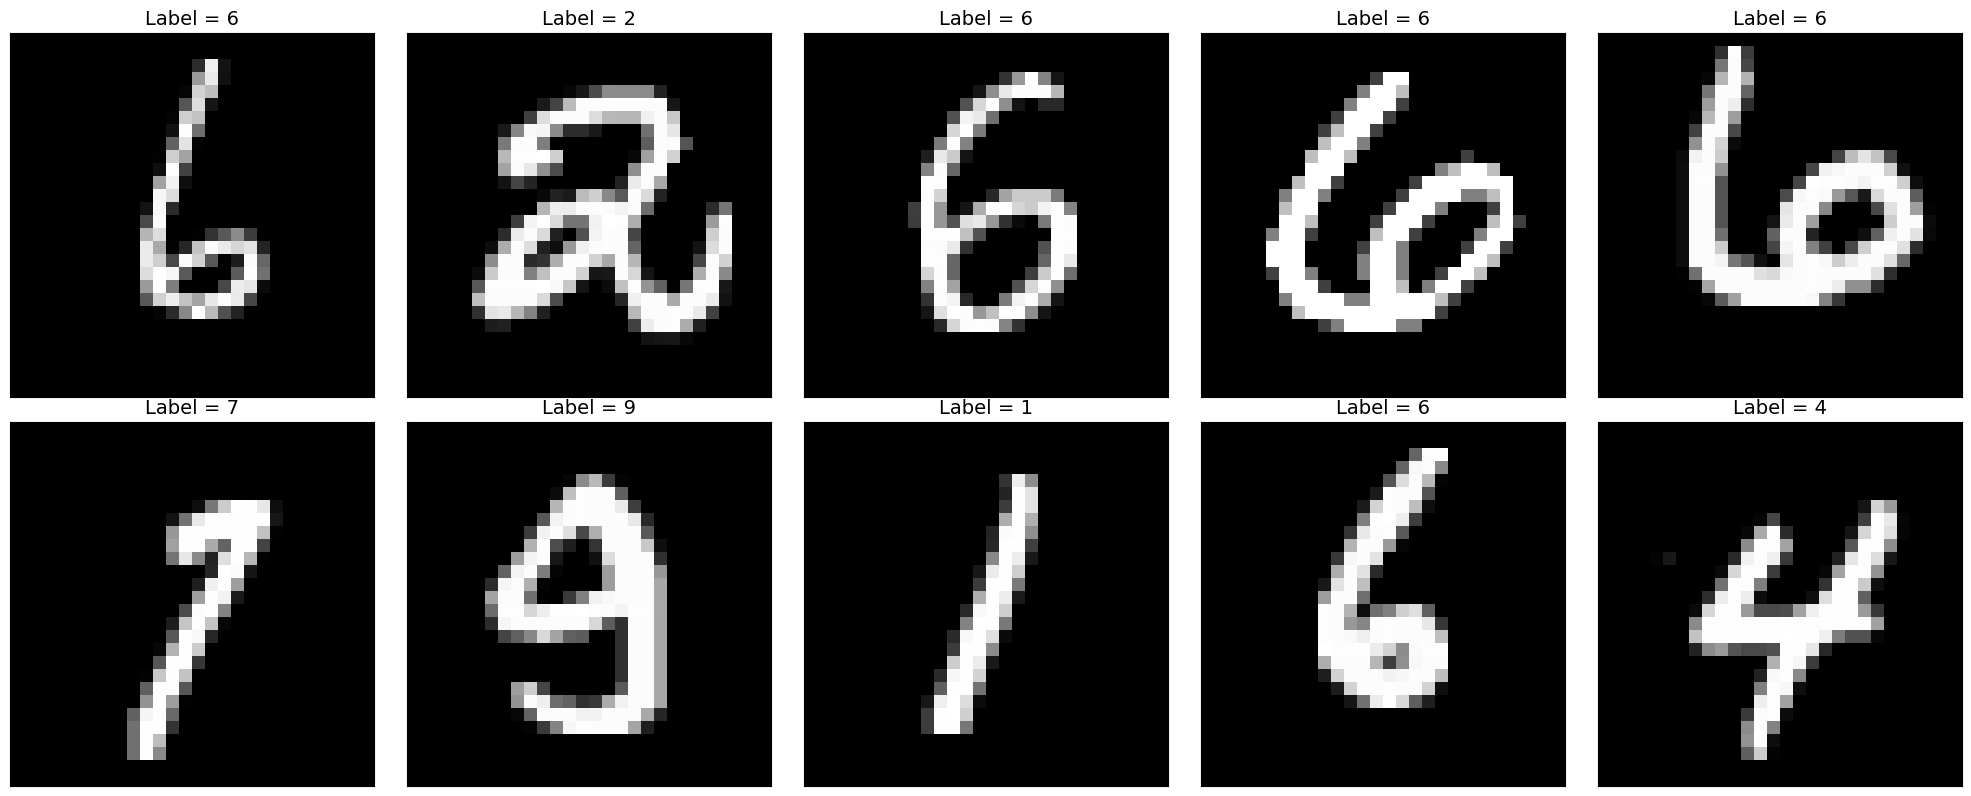

In [ ]:
# Plot sample images
plot_sample_images(x_train, y_train, n_samples=10)

## Data Preprocessing

In [ ]:
# Normalize pixel values to 0-1 range
x_train_norm, x_val_norm, x_test_norm = normalize_data(x_train, x_val, x_test)

print(f"Original pixel range: [{x_train.min()}, {x_train.max()}]")
print(f"Normalized pixel range: [{x_train_norm.min()}, {x_train_norm.max()}]")

Original pixel range: [0, 255]
Normalized pixel range: [0.0, 1.0]


## Create and Build MLP Model

### Multi-Layer Perceptron (MLP)
- **Architecture**: Fully connected layers with dropout regularization
- **Input**: Flattened 28×28 pixel images (784 features)
- **Hidden layers**: Configurable dense layers with ReLU activation
- **Output**: 10-class softmax classification
- **Use case**: Baseline model, resource-constrained environments

- Tweak the `hidden_units` list to test the effect of the model architecture on predictions

In [ ]:
input_shape, output_shape = get_input_output_shapes(x_train, y_train)

hidden_units = [32, 32, 16]  # Three hidden layers
dropout_rate = 0.1

model = create_mlp_model(
    input_shape=input_shape,
    output_shape=output_shape,
    units=hidden_units,
    p_drop=dropout_rate,
)

# Display model summary
model.summary()

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,874 (104.98 KB)

 Trainable params: 26,874 (104.98 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model

- The training process uses early stopping to avoid overfitting.
- To ensure proper convergence learning rate reduction is used when training stalls.

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7362 - loss: 0.8114 - val_accuracy: 0.9229 - val_loss: 0.2772 - learning_rate: 0.0010
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.3636 - val_accuracy: 0.9382 - val_loss: 0.2145 - learning_rate: 0.0010
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9167 - loss: 0.2906 - val_accuracy: 0.9451 - val_loss: 0.1923 - learning_rate: 0.0010
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9280 - loss: 0.2527 - val_accuracy: 0.9499 - val_loss: 0.1798 - learning_rate: 0.0010
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9347 - loss: 0.2285 - val_accuracy: 0.9552 - val_loss: 0.1578 - learning_rate: 0.0010
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9397 - loss: 0.2121 - val_accuracy: 0.9569 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9428 - loss: 0.2001 - 

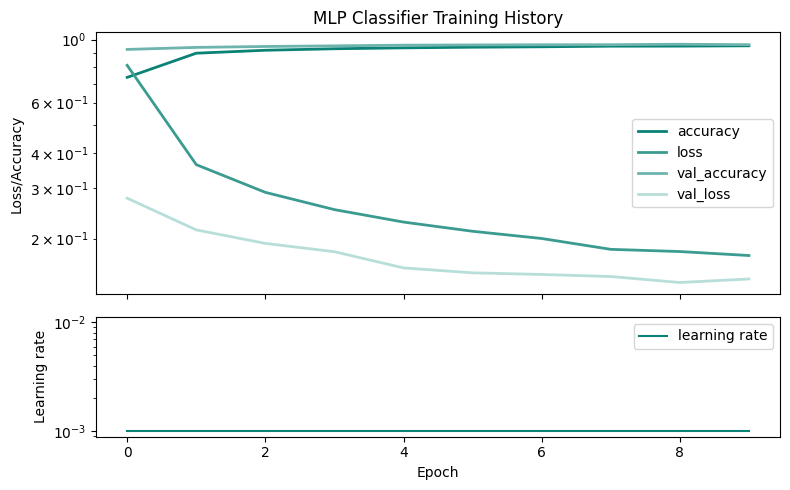

In [ ]:
# Train the model
history = train_model(
    model=model,
    x_train=x_train_norm,
    y_train=y_train,
    x_val=x_val_norm,
    y_val=y_val,
    batch_size=64,
    epochs=10,
)

plot_training_history(history, model_name="MLP Classifier")

## Evaluate Model Performance

- Classification accuracy as overall statistical metric
- Confusion matrix to see which digits the model has difficulties to classify correctly

Test Loss: 0.1432
Test Accuracy: 0.9603 (96.03%)


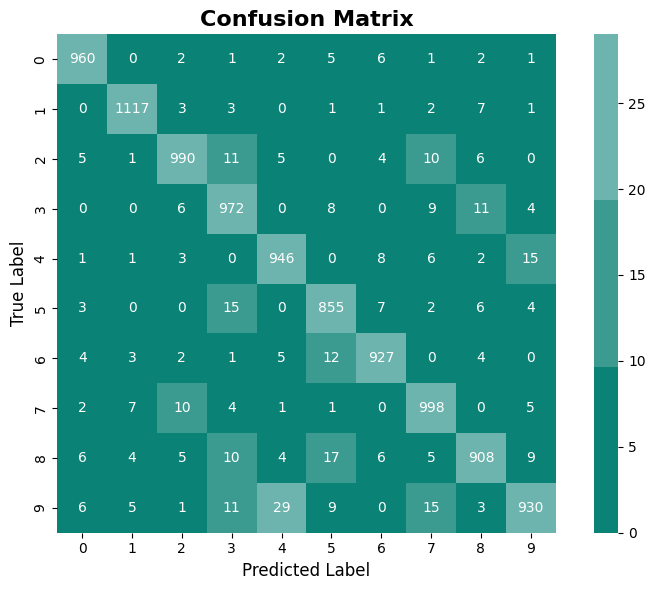

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = evaluate_model(model, x_test_norm, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Plot confusion matrix
plot_confusion_matrix(
    model, x_test_norm, y_test, class_names=[str(i) for i in range(10)]
)

# Export Model to ONNX

- Generate a model name based on its architecture and loss
- Save the model together with a test in- & output

In [ ]:
model_name = generate_model_name(model, test_accuracy, test_loss)

# Prepare input and output for model export (following RUL pattern)
input_target = x_train_norm[0]  # Shape: (28, 28) - unbatched like RUL example
output_target = get_predictions(origin, model, input_target)

save_all(model_name, input_target, output_target, model, origin)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Directory created: out/mlp_model_layers_4_param_26874_accuracy_96-03_loss_0-14/test_mlp_model_layers_4_param_26874_accuracy_96-03_loss_0-14


# Convert Model for AURIX&trade; TC3x and TC4x deployment

- Make sure the docker container with conversion tools is running
- Submit the model together with test data to the container and download the generated code, binary and log files.
- Results are saved in the `out/<model_name>/test_<model_name>/<target>/` folder

In [ ]:
ensure_docker_container()

Docker container 'heuristic_swartz' (from image 'docker-atv-sae-ai-public-registry.vih.infineon.com/tc_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


In [ ]:
from CentralScripts.python_flask_client import CallTools

model_folder, onnx_model_file = get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


## Simulated execution timing

- For each node in the neural network the number of clock cycles is extracted from the log file and plotted.
- You can inspect which node is a computational bottleneck and adjust your network if wanted.

Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


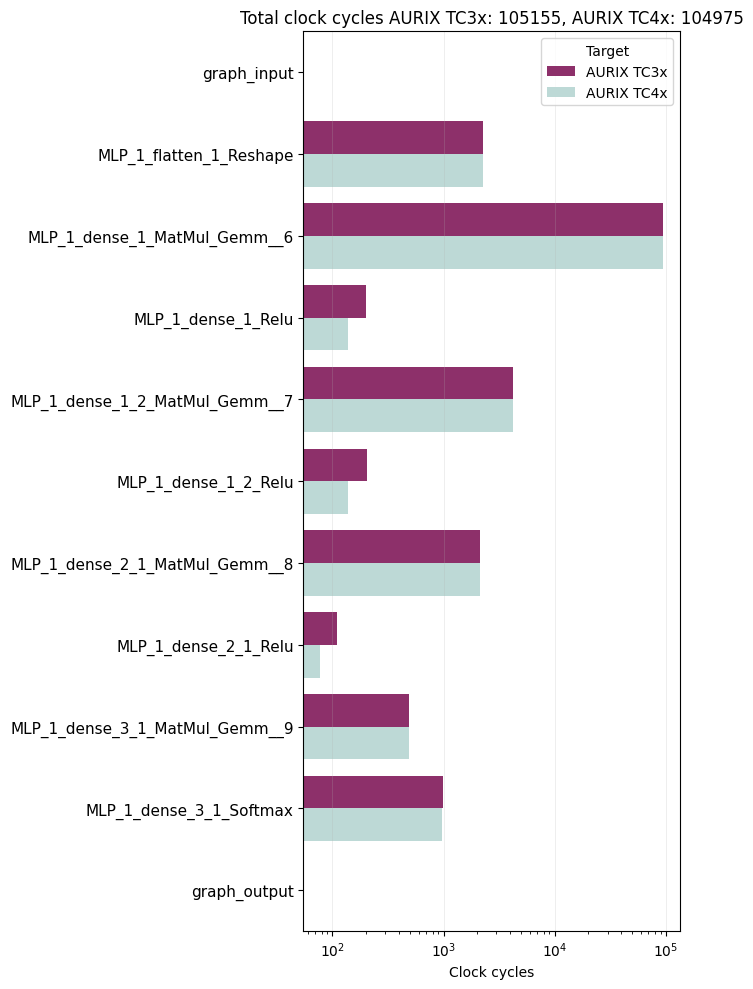

In [ ]:
plot_execution_timing(model_name)